In [1]:
from pathlib import Path
#import warnings
import scanpy as sc
import scib 
import numpy as np
import pandas as pd
import sys 

import scgpt as scg
import matplotlib.pyplot as plt

plt.style.context('default')
#warnings.simplefilter('ignore', ResourceWarning)



c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scgpt\model\model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scgpt\model\multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)




In [3]:
import sys

repo_dir = Path.cwd().parent.absolute()
sys.path.append(str(repo_dir))

from src.utils import setup_data_dir
setup_data_dir()
data_dir = repo_dir / "data"



In [4]:
file_path = data_dir / "human_pancreas_norm_complexBatch.h5ad"


In [5]:
import scanpy as sc
import scipy.sparse 

# Read the file
adata = sc.read_h5ad(file_path)

# Look at the structure and content
print("AnnData object:", adata)
print("\nShape:", adata.shape)  # (n_obs × n_vars)

# Check if X is sparse
print("\nX storage type:", type(adata.X))
if scipy.sparse.issparse(adata.X):
    print("Sparse matrix details:")
    print("- data shape:", adata.X.data.shape)
    print("- indices shape:", adata.X.indices.shape)
    print("- indptr shape:", adata.X.indptr.shape)

# Look at obs and var contents
print("\nContents of obs:", adata.obs.columns.tolist())
print("\nContents of var:", adata.var.columns.tolist())

# print some metadata
print("\nMetadata:")
print(adata.uns)
print("\nLayers:")
print(adata.layers)


'''
The var layer doesn't have a column name for the genes
'''



c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\specs\registry.py:275: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\specs\registry.py:275: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\specs\registry.py:275: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)


AnnData object: AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'

Shape: (16382, 19093)

X storage type: <class 'numpy.ndarray'>

Contents of obs: ['tech', 'celltype', 'size_factors']

Contents of var: []

Metadata:
OrderedDict()

Layers:
Layers with keys: counts


c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\utils.py:211: OldFormatWarning: Element '/obs/__categories/tech' was written without encoding metadata.
  return func(*args, **kwargs)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\utils.py:211: OldFormatWarning: Element '/obs/tech' was written without encoding metadata.
  return func(*args, **kwargs)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\utils.py:211: OldFormatWarning: Element '/obs/__categories/celltype' was written without encoding metadata.
  return func(*args, **kwargs)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\utils.py:211: OldFormatWarning: Element '/obs/celltype' was written without encoding metadata.
  return func(*args, **kwargs)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\utils.py:211: OldFormatWarning: Element '/obs/size_factors' was written without encoding metadata.
  return func(*args, **k

"\nThe var layer doesn't have a column name for the genes\n"


=== Top Cell Types ===
Top 10 most common cell types:
celltype
alpha                 5493
beta                  4169
ductal                2142
acinar                1669
delta                 1055
gamma                  699
activated_stellate     464
endothelial            313
quiescent_stellate     193
macrophage              79
Name: count, dtype: int64

Total number of cells: 16382

=== Gene Statistics ===
Total number of genes: 19093

Top 10 most expressed genes:
         gene  total_expression
6054      FTL     105541.382812
4792   EEF1A1     103842.132812
1329      B2M     103249.171875
9190   MALAT1     102346.898438
6503     GNAS      99724.718750
6052     FTH1      98417.218750
13849    RPL3      96728.156250
17424     TTR      95777.656250
13861  RPL37A      94321.656250
6209    GAPDH      93548.570312


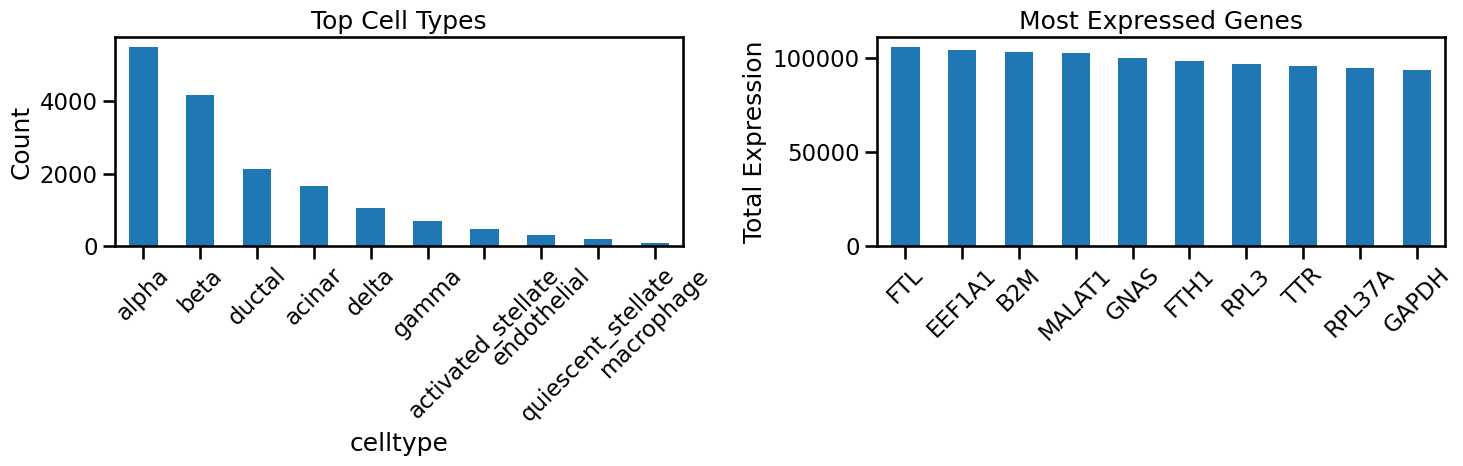

In [6]:
# 1. Most common cell types (assuming 'celltype' is in obs)
n = 10  # specify how many top cell types you want to see
cell_counts = adata.obs['celltype'].value_counts()
print("\n=== Top Cell Types ===")
print(f"Top {n} most common cell types:")
print(cell_counts.head(n))
print(f"\nTotal number of cells: {len(adata.obs)}")

# 2. Gene expression analysis
# Sum expression across cells for each gene
gene_sums = adata.X.sum(axis=0)
if scipy.sparse.issparse(adata.X):
    gene_sums = gene_sums.A1  # Convert to dense array if sparse

# Create DataFrame with gene names and their sums
gene_stats = pd.DataFrame({
    'gene': adata.var_names,
    'total_expression': gene_sums
})
gene_stats = gene_stats.sort_values('total_expression', ascending=False)

print("\n=== Gene Statistics ===")
print(f"Total number of genes: {len(adata.var_names)}")
print(f"\nTop {n} most expressed genes:")
print(gene_stats.head(n))

# 3. Optional: Visualize distributions
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Cell type distribution
cell_counts.head(n).plot(kind='bar', ax=ax1)
ax1.set_title('Top Cell Types')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Gene expression distribution
gene_stats['total_expression'].head(n).plot(kind='bar', ax=ax2)
ax2.set_title('Most Expressed Genes')
ax2.set_ylabel('Total Expression')
ax2.set_xticklabels(gene_stats['gene'].head(n), rotation=45)

plt.tight_layout()
plt.show()

In [7]:
gene_col = "Gene Symbol"
cell_type_key = "celltype"
batch_key = "tech"
N_HVG = 1800

# Gene Embeddings with scGPT 

In [8]:
# Set up of the model directory 
model_dir = repo_dir / "scGPT_data" / "scGPT_CP"

print(f"Repository directory: {repo_dir}")
print(f"Model directory: {model_dir}")

Repository directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT
Model directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\scGPT_data\scGPT_CP


In [9]:
import scanpy as sc

embed_file_path = data_dir / "human_pancreas_norm_complexBatch_embedded.h5ad"
adata_embedded = sc.read_h5ad(embed_file_path)

print(adata_embedded)

import scipy.sparse as sparse

# Check if X is a sparse matrix
is_sparse = sparse.issparse(adata.X)
print(f"Is the main matrix sparse? {is_sparse}")

# If you want to see the specific type of sparse matrix
print(f"Matrix type: {type(adata.X)}")

# Check if the counts layer is sparse
is_counts_sparse = sparse.issparse(adata.layers['counts'])
print(f"Is the counts layer sparse? {is_counts_sparse}")




AnnData object with n_obs × n_vars = 16382 × 1722
    obs: 'tech', 'celltype', 'size_factors'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'id_in_vocab'
    uns: 'hvg', 'log1p'
    obsm: 'X_scGPT'
    layers: 'counts'
Is the main matrix sparse? False
Matrix type: <class 'numpy.ndarray'>
Is the counts layer sparse? False


In [10]:

# Check if highly variable genes are present
if 'highly_variable' in adata_embedded.var.columns:
    print("\nHighly variable genes are present.")
    print(f"Number of highly variable genes: {adata_embedded.var['highly_variable'].sum()}")
else:

    print("\nHighly variable genes are not present.")


Highly variable genes are present.
Number of highly variable genes: 1722


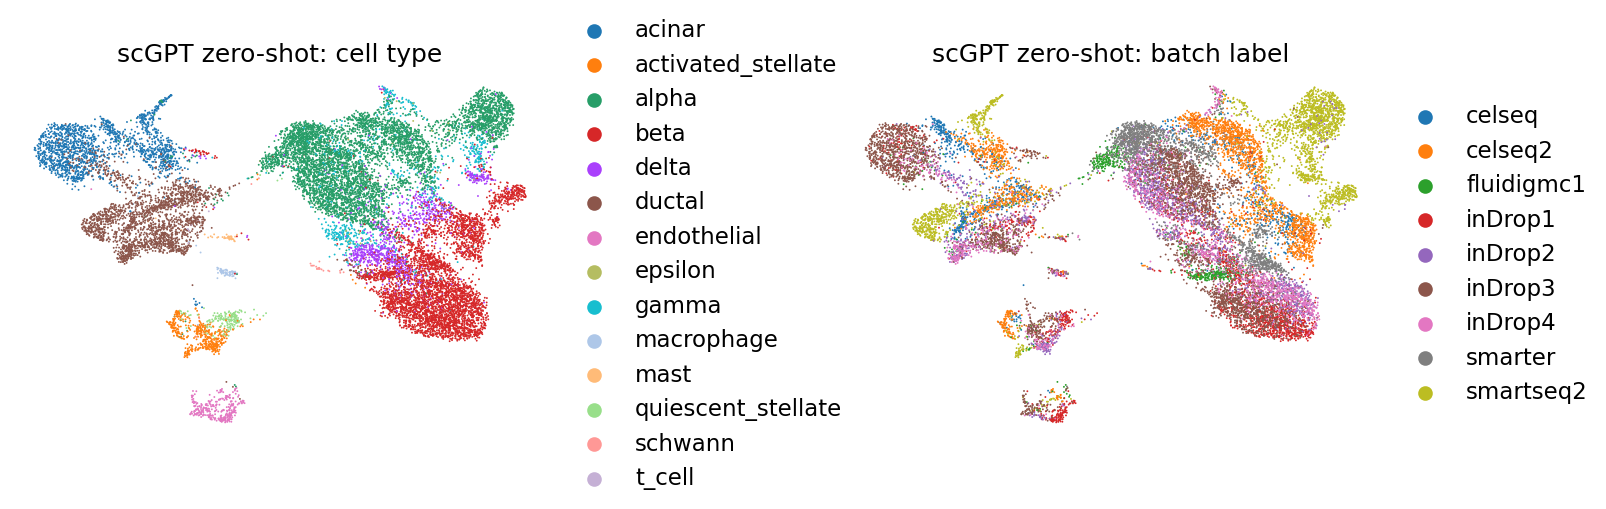

In [11]:
sc.pp.neighbors(adata_embedded, use_rep="X_scGPT")
sc.tl.umap(adata_embedded)
sc.pl.umap(adata_embedded, 
           color=[cell_type_key, batch_key], 
           frameon=False, 
           wspace=0.4, 
           title=["scGPT zero-shot: cell type", "scGPT zero-shot: batch label"])

In [12]:
"""
Calculate the metrics for integration results
"""
def scib_eval(adata, batch_key, cell_type_key, embed_key):
    results = scib.metrics.metrics(
        adata,
        adata_int=adata,
        batch_key=batch_key,
        label_key=cell_type_key,
        embed=embed_key,
        isolated_labels_asw_=False,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=True,
        pcr_=True,
        isolated_labels_f1_=False,
        trajectory_=False,
        nmi_=True,  # use the clustering, bias to the best matching
        ari_=True,  # use the clustering, bias to the best matching
        cell_cycle_=False,
        kBET_=False,  # kBET return nan sometimes, need to examine
        ilisi_=False,
        clisi_=False,
    )
    result_dict = results[0].to_dict()
    
    # compute avgBIO metrics
    result_dict["avg_bio"] = np.mean(
        [
            result_dict["NMI_cluster/label"],
            result_dict["ARI_cluster/label"],
            result_dict["ASW_label"],
        ]
    )
    
    # compute avgBATCH metrics
    result_dict["avg_batch"] = np.mean(
        [
            result_dict["graph_conn"],
            result_dict["ASW_label/batch"],
        ]
    )
    
    result_dict = {k: v for k, v in result_dict.items() if not np.isnan(v)}
    
    return result_dict

In [14]:
scib_result_dict = scib_eval(
    adata_embedded,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_scGPT",
)

Cluster for cluster_0.2 with leiden


c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scib\metrics\clustering.py:96: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=resolution_key, **kwargs)


Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...


c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scanpy\preprocessing\_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scanpy\preprocessing\_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Graph connectivity...


c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scib\metrics\graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scib\metrics\graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scib\metrics\graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scib\metrics\graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).valu

In [15]:
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

AvgBIO: 0.5898
AvgBATCH: 0.9169


In [23]:
import h5py

with h5py.File(embed_file_path, 'r') as f:
    # Look at the structure of the X group
    print("Contents of X group:", list(f['X'].shape))
    


    # Look at obs and var to get dimensions
    print("\nContents of obs group:", list(f['obs'].keys()))
    print("Contents of var group:", list(f['var'].keys()))


Contents of X group: [16382, 1722]

Contents of obs group: ['_index', 'celltype', 'size_factors', 'tech']
Contents of var group: ['_index', 'gene_name', 'highly_variable', 'highly_variable_rank', 'id_in_vocab', 'means', 'variances', 'variances_norm']


In [28]:
with h5py.File(embed_file_path, 'r') as f:
    var_group = f['var']
    feature_name = list(var_group.keys())
    print(f"\nFeature names in var group: {feature_name}")
    print(f"Total number of features: {len(feature_name)}")



Feature names in var group: ['_index', 'gene_name', 'highly_variable', 'highly_variable_rank', 'id_in_vocab', 'means', 'variances', 'variances_norm']
Total number of features: 8


In [36]:
import os
from pathlib import Path

# Print current working directory
print("Current working directory:", os.getcwd())

# Get parent directory path
parent_dir = Path(os.getcwd()).parent
print("\nParent directory:", parent_dir)

# Check the data directory in the parent folder
data_dir = parent_dir / 'data'
print("\nData directory:", data_dir)

# List files in the data directory
if data_dir.exists():
    print("\nFiles in data directory:")
    for file in os.listdir(data_dir):
        if file.endswith('.h5ad'):
            print(f"Found .h5ad file: {file}")

# Now let's use the correct path for our h5ad file
embed_file_path = parent_dir / 'data' / 'human_pancreas_norm_complexBatch_embedded.h5ad'
print("\nFull file path:", embed_file_path)
print("File exists:", embed_file_path.exists())

Current working directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\notebooks

Parent directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT

Data directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\data

Files in data directory:
Found .h5ad file: 1m_cells.h5ad
Found .h5ad file: Azimuth_meta-analysis_of_human_scRNA-seq_datasets.h5ad
Found .h5ad file: Fetal_lung_+_Pan-fetal immune.h5ad
Found .h5ad file: human_pancreas_norm_complexBatch.h5ad
Found .h5ad file: human_pancreas_norm_complexBatch_embedded.h5ad
Found .h5ad file: Stromal_cells_all_non-immune_cells.h5ad

Full file path: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\data\human_pancreas_norm_complexBatch_embedded.h5ad
File exists: True


In [37]:
import h5py

def explore_h5ad_structure(file_path):
    """
    Explore and print the structure of the .h5ad file.
    
    Args:
        file_path (str or Path): Path to the .h5ad file.
    """
    with h5py.File(file_path, 'r') as f:
        # Print top-level keys
        print("Top-level keys:", list(f.keys()))
        
        # Explore var group
        print("\nContents of var group:", list(f['var'].keys()))
        
        # Explore obs group
        print("\nContents of obs group:", list(f['obs'].keys()))
        
        # Explore X dataset
        if 'X' in f:
            print("\nX dataset shape:", f['X'].shape)
            print("X dataset type:", f['X'].dtype)

# Use the correct file path
embed_file_path = Path(os.getcwd()).parent / 'data' / 'human_pancreas_norm_complexBatch_embedded.h5ad'

if embed_file_path.exists():
    print("\nExploring file structure...")
    explore_h5ad_structure(embed_file_path)
else:
    print(f"\nFile not found at: {embed_file_path}")
    print("Please verify the exact file name in the data directory.")


Exploring file structure...
Top-level keys: ['X', 'layers', 'obs', 'obsm', 'obsp', 'uns', 'var', 'varm', 'varp']

Contents of var group: ['_index', 'gene_name', 'highly_variable', 'highly_variable_rank', 'id_in_vocab', 'means', 'variances', 'variances_norm']

Contents of obs group: ['_index', 'celltype', 'size_factors', 'tech']

X dataset shape: (16382, 1722)
X dataset type: float32


In [41]:
import h5py
import numpy as np

def explore_specific_data(file_path):
    """
    Explore specific parts of the h5ad file in detail.
    """
    with h5py.File(file_path, 'r') as f:
        # 1. Gene Names (first 10)
        print("=== First 10 Gene Names ===")
        gene_names = list(f['var']['gene_name'])  # Convert to list first
        print(gene_names[:10])
        
        # 2. Cell Types (unique values)
        print("\n=== Unique Cell Types ===")
        cell_types = list(f['obs']['celltype'])  # Convert to list first
        unique_cell_types = np.unique(cell_types)
        print(unique_cell_types)
        
        # 3. Matrix Information
        print("\n=== Matrix Information ===")
        print(f"Number of cells: {f['X'].shape[0]}")
        print(f"Number of genes: {f['X'].shape[1]}")
        
        # 4. Highly Variable Genes
        print("\n=== Highly Variable Genes Info ===")
        highly_var = list(f['var']['highly_variable'])  # Convert to list first
        n_highly_var = np.sum(highly_var)
        print(f"Number of highly variable genes: {n_highly_var}")
        
        # 5. Size Factors Information
        print("\n=== Size Factors Information ===")
        size_factors = list(f['obs']['size_factors'])  # Convert to list first
        print(f"Mean size factor: {np.mean(size_factors)}")
        print(f"Min size factor: {np.min(size_factors)}")
        print(f"Max size factor: {np.max(size_factors)}")

        # 6. Available Keys in obs
        print("\n=== Available Keys in obs ===")
        print(list(f['obs'].keys()))

# Use the correct file path
embed_file_path = Path(os.getcwd()).parent / 'data' / 'human_pancreas_norm_complexBatch_embedded.h5ad'
explore_specific_data(embed_file_path)

=== First 10 Gene Names ===
[b'A2M', b'A4GALT', b'AADAC', b'AADACL2', b'AADACL3', b'ABCC12', b'ABCC8', b'ABHD17A', b'ABI3', b'ACKR3']

=== Unique Cell Types ===
['categories' 'codes']

=== Matrix Information ===
Number of cells: 16382
Number of genes: 1722

=== Highly Variable Genes Info ===
Number of highly variable genes: 1722

=== Size Factors Information ===
Mean size factor: 0.9999999999999999
Min size factor: 0.00668105726348666
Max size factor: 39.73882116876947

=== Available Keys in obs ===
['_index', 'celltype', 'size_factors', 'tech']


In [42]:
import h5py
import pandas as pd
import numpy as np

def create_gene_dataframe(file_path):
    """
    Create a DataFrame containing gene information from the h5ad file.
    
    Args:
        file_path (Path): Path to the h5ad file
        
    Returns:
        pd.DataFrame: DataFrame containing gene information
    """
    with h5py.File(file_path, 'r') as f:
        # Get all the data from var group
        gene_data = {
            'gene_name': list(f['var']['gene_name']),
            'id_in_vocab': list(f['var']['id_in_vocab']),
            'highly_variable': list(f['var']['highly_variable']),
            'highly_variable_rank': list(f['var']['highly_variable_rank']),
            'means': list(f['var']['means']),
            'variances': list(f['var']['variances']),
            'variances_norm': list(f['var']['variances_norm'])
        }
        
        # Create DataFrame
        gene_df = pd.DataFrame(gene_data)
        
        # Add index from _index if it exists
        if '_index' in f['var']:
            gene_df.index = list(f['var']['_index'])
    
    return gene_df

# Create the DataFrame
embed_file_path = Path(os.getcwd()).parent / 'data' / 'human_pancreas_norm_complexBatch_embedded.h5ad'
gene_df = create_gene_dataframe(embed_file_path)

# Display basic information about the DataFrame
print("DataFrame Info:")
print(gene_df.info())

print("\nFirst few rows of the DataFrame:")
print(gene_df.head())

# Display some basic statistics
print("\nSummary Statistics:")
print(gene_df.describe())

# Count of highly variable genes
print("\nNumber of highly variable genes:", gene_df['highly_variable'].sum())

# Save to CSV (optional)
# gene_df.to_csv('gene_information.csv')

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1722 entries, b'A2M' to b'ZP4'
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gene_name             1722 non-null   object 
 1   id_in_vocab           1722 non-null   int64  
 2   highly_variable       1722 non-null   bool   
 3   highly_variable_rank  1722 non-null   float32
 4   means                 1722 non-null   float64
 5   variances             1722 non-null   float64
 6   variances_norm        1722 non-null   float64
dtypes: bool(1), float32(1), float64(3), int64(1), object(1)
memory usage: 89.1+ KB
None

First few rows of the DataFrame:
             gene_name  id_in_vocab  highly_variable  highly_variable_rank  \
b'A2M'          b'A2M'            3             True                1747.0   
b'A4GALT'    b'A4GALT'            9             True                1741.0   
b'AADAC'      b'AADAC'           14             True        

In [47]:
import mygene
import pandas as pd

gene_df['clean_gene_name'] = gene_df['gene_name'].str.decode('utf-8')


mg = mygene.MyGeneInfo()

# Query mygene for the gene symbols
results = mg.querymany(gene_df['clean_gene_name'].tolist(), 
                      scopes='symbol', 
                      fields='ensembl.gene', 
                      species='human')


# Create a dictionary to store gene symbol to Ensembl ID mappings
ensembl_dict = {}
for r in results:
    if 'ensembl' in r:
        ensembl_dict[r['query']] = r['ensembl']['gene'] if isinstance(r['ensembl'], dict) else r['ensembl'][0]['gene']
    else:
        ensembl_dict[r['query']] = None

# Add Ensembl IDs as a new column
gene_df['ensembl_id'] = gene_df['clean_gene_name'].map(ensembl_dict)

# Display the updated DataFrame
print(gene_df[['clean_gene_name', 'ensembl_id']].head())


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
37 input query terms found dup hits:	[('BCORP1', 2), ('BCRP2', 2), ('BIRC8', 2), ('CBX3P4', 2), ('CD99P1', 3), ('CFL1P1', 3), ('CYP4F29P'
20 input query terms found no hit:	['C10orf99', 'C11orf53', 'C11orf94', 'C16orf97', 'C17orf98', 'C1orf194', 'C7orf69', 'C9orf135', 'C9o


           clean_gene_name       ensembl_id
b'A2M'                 A2M  ENSG00000175899
b'A4GALT'           A4GALT  ENSG00000128274
b'AADAC'             AADAC  ENSG00000114771
b'AADACL2'         AADACL2  ENSG00000197953
b'AADACL3'         AADACL3  ENSG00000188984


In [49]:
# Assuming you have your previous DataFrame with gene_df
formatted_gene_info = pd.DataFrame({
    'gene_name': gene_df['clean_gene_name'],
    'ensembl_id': gene_df['ensembl_id'],
    'gene_type': 'protein_coding'  # Default value, or you can leave it empty initially
})

# If you want to save it in a similar format
from datasets import Dataset

# Convert pandas DataFrame to Hugging Face dataset
hf_dataset = Dataset.from_pandas(formatted_gene_info)

# You can then use it like:
print(hf_dataset.to_pandas().head())

  gene_name       ensembl_id       gene_type __index_level_0__
0       A2M  ENSG00000175899  protein_coding            b'A2M'
1    A4GALT  ENSG00000128274  protein_coding         b'A4GALT'
2     AADAC  ENSG00000114771  protein_coding          b'AADAC'
3   AADACL2  ENSG00000197953  protein_coding        b'AADACL2'
4   AADACL3  ENSG00000188984  protein_coding        b'AADACL3'


In [67]:
import mygene

# Initialize mygene client
mg = mygene.MyGeneInfo()

# Query gene information using Ensembl IDs
results = mg.querymany(
    gene_df['ensembl_id'].dropna().tolist(),
    scopes='ensembl.gene',
    fields=['type_of_gene', 'name'],
    species='human'
)

# Create a dictionary for gene types
gene_type_dict = {}
for r in results:
    if 'type_of_gene' in r:
        gene_type_dict[r['query']] = r['type_of_gene']

# Create formatted DataFrame with proper gene types
formatted_gene_info = pd.DataFrame({
    'gene_name': gene_df['clean_gene_name'],
    'ensembl_id': gene_df['ensembl_id'],
    'gene_type': gene_df['ensembl_id'].map(gene_type_dict)
})

# Convert to HF dataset
hf_dataset = Dataset.from_pandas(formatted_gene_info)

# Display distribution of gene types
print("Gene type distribution:")
print(formatted_gene_info['gene_type'].value_counts())

# Display first few rows
print("\nSample of genes:")
print(formatted_gene_info.head())

# Count occurrences of each ensembl_id
ensembl_counts = formatted_gene_info['ensembl_id'].value_counts()

print("\nEnsembl ID counts:")
print(ensembl_counts)

# Print summary statistics
print(f"\nTotal unique Ensembl IDs: {len(ensembl_counts)}")
print(f"Number of genes with multiple Ensembl IDs: {sum(ensembl_counts > 1)}")
if sum(ensembl_counts > 1) > 0:
    print("\nGenes with multiple Ensembl IDs:")
    print(ensembl_counts[ensembl_counts > 1])


Input sequence provided is already in string format. No operation performed


Gene type distribution:
gene_type
protein-coding    1635
pseudo              14
ncRNA               14
other                6
Name: count, dtype: int64

Sample of genes:
           gene_name       ensembl_id       gene_type
b'A2M'           A2M  ENSG00000175899  protein-coding
b'A4GALT'     A4GALT  ENSG00000128274  protein-coding
b'AADAC'       AADAC  ENSG00000114771  protein-coding
b'AADACL2'   AADACL2  ENSG00000197953  protein-coding
b'AADACL3'   AADACL3  ENSG00000188984  protein-coding

Ensembl ID counts:
ensembl_id
ENSG00000175899    1
ENSG00000239883    1
ENSG00000004799    1
ENSG00000185615    1
ENSG00000113721    1
                  ..
ENSG00000145321    1
ENSG00000107485    1
ENSG00000179348    1
ENSG00000102145    1
ENSG00000116996    1
Name: count, Length: 1690, dtype: int64

Total unique Ensembl IDs: 1690
Number of genes with multiple Ensembl IDs: 0


In [64]:
# Create DataFrame with the embeddings
embeddings = pd.DataFrame(
    adata_embedded.obsm["X_scGPT"],
    columns=[f'dim_{i}' for i in range(adata_embedded.obsm["X_scGPT"].shape[1])]
)

embeddings.head()


,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_502,dim_503,dim_504,dim_505,dim_506,dim_507,dim_508,dim_509,dim_510,dim_511
0,0.073707,0.003733,0.012353,0.045787,0.028686,-0.056230,-0.011507,-0.010013,0.009184,-0.000568,...,0.008169,0.018345,-0.009001,-0.054426,-0.005338,0.053253,-0.018662,-0.061871,-0.006637,0.016113
1,0.071376,-0.001319,0.009428,0.041126,0.030103,-0.045669,-0.007892,-0.011339,0.009670,-0.014000,...,-0.006212,0.013708,-0.002215,-0.025881,-0.011843,0.039152,-0.011095,-0.070091,-0.012862,0.012441
2,0.071767,-0.001087,0.003495,0.024505,0.013971,-0.056813,-0.007876,-0.013006,0.005641,-0.000393,...,0.009032,0.019963,-0.002741,-0.034292,-0.014005,0.037931,-0.015522,-0.066543,-0.006534,0.017417
3,0.068650,-0.009042,0.010772,0.032528,0.003143,-0.059393,-0.001724,-0.005239,0.000050,-0.000701,...,0.006416,0.015484,-0.005555,-0.036029,-0.018596,0.053356,-0.017171,-0.065435,-0.007440,0.014150
4,0.050278,-0.014192,0.012542,0.025254,0.020374,-0.052632,0.018501,0.036703,-0.000850,0.045470,...,0.040856,0.048323,-0.023896,-0.073116,0.044221,0.069515,0.012028,-0.073033,-0.030490,-0.001478


In [68]:
# 1. Check your AnnData object structure
print("AnnData Structure:")
print(f"Shape: {adata_embedded.shape}")  # (cells × genes)
print("\nAvailable fields:")
print(f"obs: {list(adata_embedded.obs.columns)}")
print(f"var: {list(adata_embedded.var.columns)}")
print(f"obsm: {list(adata_embedded.obsm.keys())}")
print(f"layers: {list(adata_embedded.layers.keys())}")

# 2. Check embeddings structure
print("\nEmbeddings (X_scGPT) shape:")
print(adata_embedded.obsm["X_scGPT"].shape)  # Should be (cells × 512)

# 3. Check gene information
print("\nFirst few genes:")
print(adata_embedded.var_names[:5])

# 4. Check your gene_df structure
print("\nGene DataFrame info:")
print(gene_df.info())
print("\nFirst few rows of gene_df:")
print(gene_df.head())

# 5. Check merged_embeddings structure (if you have it)
print("\nMerged embeddings info:")
print(merged_embeddings.info())
print("\nFirst few rows of merged_embeddings:")
print(merged_embeddings.head())

# 6. Check for any missing values
print("\nMissing values in gene_df:")
print(gene_df.isnull().sum())

print("\nMissing values in merged_embeddings:")
print(merged_embeddings.isnull().sum())

# 7. Check unique Ensembl IDs
print("\nNumber of unique Ensembl IDs:", len(gene_df['ensembl_id'].unique()))

# 8. Optional: Check data types and values
print("\nSample of embedding values:")
print(adata_embedded.obsm["X_scGPT"][:5, :5])  # First 5 cells, first 5 dimensions

AnnData Structure:
Shape: (16382, 1722)

Available fields:
obs: ['tech', 'celltype', 'size_factors']
var: ['gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'id_in_vocab']
obsm: ['X_scGPT']
layers: ['counts']

Embeddings (X_scGPT) shape:
(16382, 512)

First few genes:
Index(['A2M', 'A4GALT', 'AADAC', 'AADACL2', 'AADACL3'], dtype='object')

Gene DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 1722 entries, b'A2M' to b'ZP4'
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gene_name             1722 non-null   object 
 1   id_in_vocab           1722 non-null   int64  
 2   highly_variable       1722 non-null   bool   
 3   highly_variable_rank  1722 non-null   float32
 4   means                 1722 non-null   float64
 5   variances             1722 non-null   float64
 6   variances_norm        1722 non-null   float64
 7   clean_gene_name    

In [70]:
def create_embedding_matrix(merged_embeddings, major_ensembl_ids):
    """
    Create a reordered embedding matrix that aligns gene embeddings with expression matrix columns.
    
    Args:
        merged_embeddings (pd.DataFrame): DataFrame containing gene embeddings with 'ensembl_id' column
        major_ensembl_ids (pd.Series): Series of Ensembl IDs in the order they appear in expression matrix
    
    Returns:
        tuple: (embedding_matrix, valid_indices)
            - embedding_matrix: numpy array of shape (n_embedding_dims, n_valid_genes)
            - valid_indices: list of indices mapping to original expression matrix columns
    """
    # Get the embedding values without the metadata columns
    embedding_cols = [col for col in merged_embeddings.columns 
                     if col not in ['ensembl_id']]
    
    # Create a mapping from major_ensembl_ids to column indices in cell_gene_matrix
    gene_idx_map = {gene_id: idx for idx, gene_id in enumerate(major_ensembl_ids)}
    
    # Find which embeddings correspond to genes in our expression matrix
    # and get their indices in the correct order
    valid_indices = []
    embedding_indices = []
    for i, ensembl_id in enumerate(merged_embeddings.ensembl_id):
        if ensembl_id in gene_idx_map:
            valid_indices.append(gene_idx_map[ensembl_id])
            embedding_indices.append(i)
    
    # Create the reordered embedding matrix
    embedding_matrix = merged_embeddings[embedding_cols].iloc[embedding_indices].values.T
    
    return embedding_matrix, valid_indices

In [71]:
# First, make sure we have the right gene IDs
major_ensembl_ids = gene_df['ensembl_id']  # Your Ensembl IDs in the original order

# Create embedding matrix
embedding_matrix, valid_indices = create_embedding_matrix(
    merged_embeddings,  # Your processed embeddings from earlier
    major_ensembl_ids
)

# Check the results
print("Embedding matrix shape:", embedding_matrix.shape)  # Should be (512 × n_genes)
print("Number of valid genes:", len(valid_indices))
print("Percentage of genes matched:", len(valid_indices)/len(major_ensembl_ids)*100, "%")

# Optional: Check alignment
print("\nChecking alignment of first few genes:")
for i in range(min(5, len(valid_indices))):
    original_gene = gene_df.index[valid_indices[i]]
    embedding_gene = merged_embeddings.iloc[i]['ensembl_id']
    print(f"Original gene: {original_gene}, Embedding gene: {embedding_gene}")

Embedding matrix shape: (512, 0)
Number of valid genes: 0
Percentage of genes matched: 0.0 %

Checking alignment of first few genes:


In [76]:
import numpy as np
import pandas as pd
import scipy.sparse

# 1. Create DataFrame with cell-level embeddings
cell_embeddings = pd.DataFrame(
    adata_embedded.obsm["X_scGPT"],
    columns=[f'dim_{i}' for i in range(512)]
)

# 2. Create gene-level embeddings DataFrame
gene_embeddings = pd.DataFrame(
    index=adata_embedded.var_names,
    columns=[f'dim_{i}' for i in range(512)]
)

# Calculate mean embeddings for each gene
print("Calculating gene-level embeddings...")
for gene_idx, gene_name in enumerate(adata_embedded.var_names):
    gene_expression = adata_embedded.X[:, gene_idx]
    if scipy.sparse.issparse(gene_expression):
        gene_expression = gene_expression.toarray().flatten()
    gene_mask = gene_expression > 0
    
    if gene_mask.any():
        gene_embeddings.loc[gene_name] = np.array(cell_embeddings.loc[gene_mask].mean())
    else:
        gene_embeddings.loc[gene_name] = np.zeros(512)

# 3. Clean up gene_df Ensembl IDs
print("\nCleaning up Ensembl IDs...")
# Convert byte strings to regular strings if needed
if gene_df.index.dtype == object and isinstance(gene_df.index[0], bytes):
    gene_df.index = gene_df.index.str.decode('utf-8')

# Create clean mapping dictionary
ensembl_map = gene_df['ensembl_id'].to_dict()

# 4. Add clean Ensembl IDs to gene embeddings
gene_embeddings['ensembl_id'] = gene_embeddings.index.map(ensembl_map)

# Create merged embeddings
merged_embeddings = gene_embeddings.copy()
merged_embeddings.index.name = 'gene_name'
merged_embeddings = merged_embeddings.reset_index()

# Verify data
print("\nMerged embeddings info:")
print(merged_embeddings.info())
print("\nNumber of NaN values:", merged_embeddings.isna().sum().sum())
print("Number of unique Ensembl IDs:", merged_embeddings['ensembl_id'].nunique())

# 5. Create embedding matrix with clean Ensembl IDs
embedding_matrix, valid_indices = create_embedding_matrix(
    merged_embeddings,
    gene_df['ensembl_id']  # Use clean Ensembl IDs
)

# 6. Check results
print("\nEmbedding matrix shape:", embedding_matrix.shape)
print("Number of valid genes:", len(valid_indices))
print("Percentage of genes matched:", len(valid_indices)/len(gene_df)*100, "%")

# 7. Check alignment of first few genes
print("\nChecking alignment of first few genes:")
for i in range(min(5, len(valid_indices))):
    original_gene = gene_df.index[valid_indices[i]]
    embedding_gene = merged_embeddings.iloc[i]['ensembl_id']
    print(f"Original gene: {original_gene}, Embedding gene: {embedding_gene}")

# 8. Optional: Save the results
# np.save('gene_embedding_matrix.npy', embedding_matrix)
# pd.DataFrame({'valid_indices': valid_indices}).to_csv('valid_indices.csv')

Calculating gene-level embeddings...

Cleaning up Ensembl IDs...

Merged embeddings info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1722 entries, 0 to 1721
Columns: 514 entries, gene_name to ensembl_id
dtypes: object(514)
memory usage: 6.8+ MB
None

Number of NaN values: 32
Number of unique Ensembl IDs: 1690

Embedding matrix shape: (513, 1722)
Number of valid genes: 1722
Percentage of genes matched: 100.0 %

Checking alignment of first few genes:
Original gene: A2M, Embedding gene: ENSG00000175899
Original gene: A4GALT, Embedding gene: ENSG00000128274
Original gene: AADAC, Embedding gene: ENSG00000114771
Original gene: AADACL2, Embedding gene: ENSG00000197953
Original gene: AADACL3, Embedding gene: ENSG00000188984


In [77]:
# Add validation and cleanup steps
print("\nValidation Steps:")

# 1. Check for duplicate Ensembl IDs
duplicates = merged_embeddings['ensembl_id'].value_counts()
print("\nDuplicate Ensembl IDs:")
print(duplicates[duplicates > 1].head())

# 2. Check genes with missing Ensembl IDs
missing_ids = merged_embeddings[merged_embeddings['ensembl_id'].isna()]
print("\nGenes with missing Ensembl IDs:")
print(missing_ids['gene_name'].head())

# 3. Verify embedding values
print("\nEmbedding statistics:")
embedding_values = merged_embeddings[[f'dim_{i}' for i in range(512)]].values
print(f"Mean: {np.mean(embedding_values):.6f}")
print(f"Std: {np.std(embedding_values):.6f}")
print(f"Min: {np.min(embedding_values):.6f}")
print(f"Max: {np.max(embedding_values):.6f}")

# 4. Save the cleaned embeddings
cleaned_embeddings = merged_embeddings.dropna(subset=['ensembl_id'])
print(f"\nFinal shape after removing NaN: {cleaned_embeddings.shape}")

# Optional: Save the results
# cleaned_embeddings.to_parquet('gene_embeddings.parquet')
# np.save('embedding_matrix.npy', embedding_matrix)


Validation Steps:

Duplicate Ensembl IDs:
Series([], Name: count, dtype: int64)

Genes with missing Ensembl IDs:
137    C10orf99
138    C11orf53
140    C11orf94
142    C16orf97
143    C17orf98
Name: gene_name, dtype: object

Embedding statistics:
Mean: 0.000717
Std: 0.040359
Min: -0.561608
Max: 0.480891

Final shape after removing NaN: (1690, 514)


In [79]:
def load_cell_metadata(adata, start_row=0, n_rows=1000, columns=None):
    """
    Load metadata for specific cells from AnnData object.
    
    Args:
        adata: AnnData object containing cell metadata
        start_row: Starting row index
        n_rows: Number of rows to load
        columns: List of metadata columns to load (if None, load all)
    
    Returns:
        Dictionary of metadata arrays
    """
    metadata = {}
    
    # Get all column names if none specified
    obs_keys = list(adata.obs.columns) if columns is None else columns
    
    # Load each requested column
    for key in obs_keys:
        if key in adata.obs.columns:
            # Get the data and convert to numpy array
            values = adata.obs[key].values[start_row:start_row + n_rows]
            
            # Convert categorical data to strings if necessary
            if pd.api.types.is_categorical_dtype(values):
                values = values.astype(str)
            
            metadata[key] = values
    
    return metadata

# Example usage:
metadata = load_cell_metadata(
    adata_embedded,  # Your AnnData object
    start_row=0, 
    n_rows=len(adata_embedded),  # Get all cells
    columns=['tech', 'celltype', 'size_factors']  # Your available columns
)

print("Loaded metadata keys:", list(metadata.keys()))

# Print first few values of each column
for key in metadata:
    print(f"\nFirst 5 values of {key}:")
    print(metadata[key][:5])

Loaded metadata keys: ['tech', 'celltype', 'size_factors']

First 5 values of tech:
['celseq' 'celseq' 'celseq' 'celseq' 'celseq']

First 5 values of celltype:
['gamma' 'gamma' 'gamma' 'gamma' 'gamma']

First 5 values of size_factors:
[0.02849223 0.07934809 0.03793206 0.04768511 0.03868266]


C:\Users\annel\AppData\Local\Temp\ipykernel_38900\1265239164.py:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values):
C:\Users\annel\AppData\Local\Temp\ipykernel_38900\1265239164.py:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values):
C:\Users\annel\AppData\Local\Temp\ipykernel_38900\1265239164.py:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values):


In [82]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import numpy as np

# Prepare the data
X = pd.DataFrame(adata_embedded.obsm["X_scGPT"])  # Get embeddings
y = adata_embedded.obs['celltype']  # Get cell types

# Define number of folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
results = []

# Perform k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\n=== Cross Validation Fold {fold + 1}/{n_splits} ===")
    
    # Subsample training data to get balanced representation per cell type
    train_indices = []
    for class_label in y.unique():
        # Get indices for this class from training set
        class_mask = y.iloc[train_idx] == class_label
        class_indices = train_idx[class_mask]
        
        # Randomly sample up to 1000 indices
        if len(class_indices) > 0:
            n_samples = min(1000, len(class_indices))
            sampled_indices = np.random.choice(class_indices, size=n_samples, replace=False)
            train_indices.extend(sampled_indices)
    
    # Create the final train/test splits
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_idx]
    
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print("\nTraining class distribution:")
    print(y_train.value_counts().sort_index())
    
    # Train and evaluate models
    models = {
        'KNN': KNeighborsClassifier(n_neighbors=10),
        'Random Forest': RandomForestClassifier(random_state=42),
        'LightGBM': LGBMClassifier(random_state=42, class_weight='balanced')
    }
    
    for name, model in models.items():
        print(f"\n{name} Results:")
        print("-" * 50)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        valid_classes = sorted(set(y_test))
        # Generate report only for classes that exist in the data
        report = classification_report(y_test, y_pred, 
                        labels=valid_classes,
                        zero_division=0,
                        output_dict=True,
                        )        
        # Store results
        results.append({
            'fold': fold + 1,
            'model': name,
            'macro_avg_f1': report['macro avg']['f1-score'],
            'weighted_avg_f1': report['weighted avg']['f1-score'],
            'train_size': len(X_train),
            'test_size': len(X_test)
        })
        
        print(classification_report(y_test, y_pred))

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df.round(3))

# Optional: Calculate average performance across folds
print("\nAverage Performance by Model:")
avg_results = results_df.groupby('model')[['macro_avg_f1', 'weighted_avg_f1']].mean().round(3)
print(avg_results)

# Optional: Save results
# results_df.to_csv('classification_results.csv', index=False)


=== Cross Validation Fold 1/5 ===
Training set size: 6298
Test set size: 3277

Training class distribution:
celltype
acinar                1000
activated_stellate     375
alpha                 1000
beta                  1000
delta                  813
ductal                1000
endothelial            252
epsilon                 26
gamma                  549
macrophage              64
mast                    31
quiescent_stellate     163
schwann                 20
t_cell                   5
Name: count, dtype: int64

KNN Results:
--------------------------------------------------
                    precision    recall  f1-score   support

            acinar       0.95      0.99      0.97       317
activated_stellate       0.94      0.96      0.95        89
             alpha       0.96      0.96      0.96      1076
              beta       0.98      0.96      0.97       853
             delta       0.74      0.86      0.80       242
            ductal       0.97      0.95      0.96   